# **ASSIGNMENT 5(i)**

Name: Alena Maria Thomas

Roll No: MDS202303

## 1. Import all the required libraries.

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Create a dataset with the images stored in Google Drive and label them.

Identify the Google Drive directory containing the images.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
chicken_dir = '/content/drive/MyDrive/AML_Asgmt_5_datasets/chicken_images'
duck_dir = '/content/drive/MyDrive/AML_Asgmt_5_datasets/duck_images'

Create a list of all the images in the directory and list of the corresponding labels.

In [10]:
images = []
labels = []

for img in os.listdir(chicken_dir):
  img_path = chicken_dir + '/' + img
  img_arr = cv2.imread(img_path)
  img_arr = cv2.resize(img_arr, (224,224))
  images.append(img_arr)
  labels.append(0)

for img in os.listdir(duck_dir):
  img_path = duck_dir + '/' + img
  img_arr = cv2.imread(img_path)
  img_arr = cv2.resize(img_arr, (224,224))
  images.append(img_arr)
  labels.append(1)

df = pd.DataFrame({'images': images, 'label': labels})

## 3. Split the dataset into training/validation/testing datasets.

In [16]:
X = np.array([np.array(img) for img in df['images']])
y = df['label'].values

Split the dataset in the following proportions:
 - 70% is training set
 - 15% is validation set
 - 15% is testing set

In [17]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=100)

## 4. Preprocess the images.

Normalize the images.

In [31]:
X_train = X_train/255.0
X_val = X_val/225.0
X_test = X_test/225.0

## 5. Model training

### 5.1 Model Building

We use the VGG-19 pre-trained model to classify chicken and duck.

Firstly, import VGG-19.

In [35]:
IMAGE_SIZE = [224, 224]

vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [36]:
# do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
  layer.trainable = False

Next, to customize the model, change its last layer alone according to the number of classes in the problem (2, in this case).

In [37]:
x = Flatten()(vgg.output)

# adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [38]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 5.2 Compile the model.

In [40]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 5.3 Fit the model.

In [42]:
# Early stopping to avoid overfitting of model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [43]:
# fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs = 10,
    callbacks = [early_stop],
    batch_size = 32,
    shuffle = True
)

Epoch 1/10
6/6 [==============================] - 211s 37s/step - loss: 1.7136 - accuracy: 0.4969 - val_loss: 0.9453 - val_accuracy: 0.5000
Epoch 2/10
6/6 [==============================] - 165s 28s/step - loss: 0.6367 - accuracy: 0.7143 - val_loss: 0.3394 - val_accuracy: 0.8235
Epoch 3/10
6/6 [==============================] - 208s 37s/step - loss: 0.2408 - accuracy: 0.9068 - val_loss: 0.3614 - val_accuracy: 0.8235
Epoch 4/10
6/6 [==============================] - 181s 31s/step - loss: 0.3169 - accuracy: 0.8447 - val_loss: 0.2969 - val_accuracy: 0.8529
Epoch 5/10
6/6 [==============================] - 193s 34s/step - loss: 0.1705 - accuracy: 0.9255 - val_loss: 0.3277 - val_accuracy: 0.8235
Epoch 6/10
6/6 [==============================] - 227s 38s/step - loss: 0.0787 - accuracy: 0.9814 - val_loss: 0.4194 - val_accuracy: 0.8235
Epoch 7/10
6/6 [==============================] - 179s 29s/step - loss: 0.0493 - accuracy: 0.9876 - val_loss: 0.3885 - val_accuracy: 0.8235
Epoch 8/10
6/6 [====

## 6. Plot the loss and accuracy.

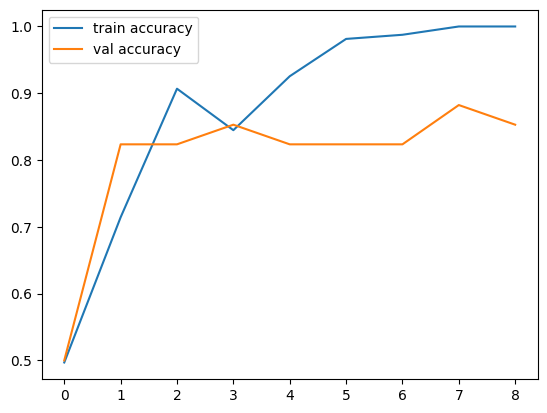

In [44]:
# accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

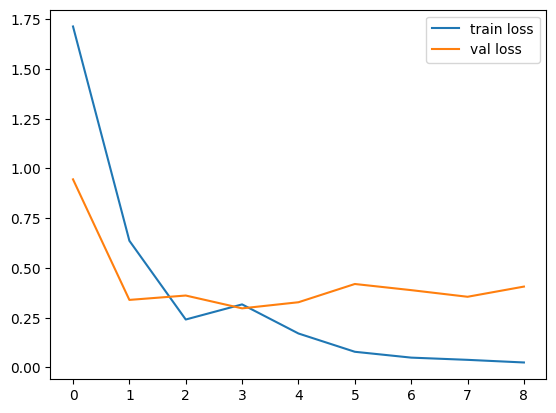

In [45]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## 7. Model Evaluation

In [46]:
# testing accuracy
model.evaluate(X_test, y_test, batch_size = 32)

2/2 [==============================] - 27s 2s/step - loss: 0.1967 - accuracy: 0.9143


[0.1966887265443802, 0.9142857193946838]

In [47]:
# classification report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_pred, y_test))

2/2 [==============================] - 27s 2s/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.85      0.92        20

    accuracy                           0.91        35
   macro avg       0.92      0.93      0.91        35
weighted avg       0.93      0.91      0.91        35



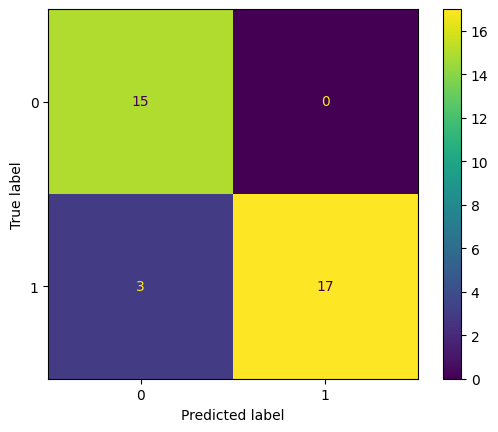

In [50]:
# confusion matrix
cm = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()